In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from IPython.display import Image 
import sklearn
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

# Reading the Data

In [2]:
books = pd.read_csv('Books_dataset.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('Users_dataset.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('Ratings_dataset.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.p

## Ratings data

In [3]:
# The ratings data set provides a list of ratings that users have given to books. 
# It includes 1,149,780 records and 3 fields: userID, ISBN, and bookRating.
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


In [4]:
ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## Ratings distribution

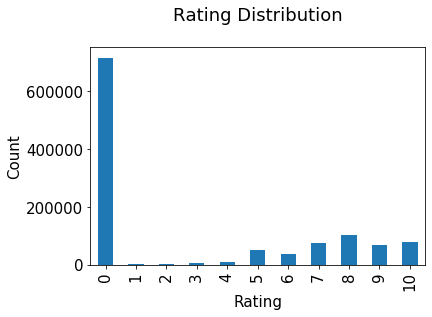

In [5]:
# The ratings are very unevenly distributed, and the vast majority of ratings are 0.
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

## Books data

In [6]:
# The books dataset provides book details. It includes 271,360 records and 8 fields: ISBN, book title, book author, publisher and so on.
print(books.shape)
print(list(books.columns))

(271360, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [7]:
books.head().T

,0,1,2,3,4
ISBN,0195153448,0002005018,0060973129,0374157065,0393045218
bookTitle,Classical Mythology,Clara Callan,Decision in Normandy,Flu: The Story of the Great Influenza Pandemic...,The Mummies of Urumchi
bookAuthor,Mark P. O. Morford,Richard Bruce Wright,Carlo D'Este,Gina Bari Kolata,E. J. W. Barber
yearOfPublication,2002,2001,1991,1999,1999
publisher,Oxford University Press,HarperFlamingo Canada,HarperPerennial,Farrar Straus Giroux,W. W. Norton &amp; Company
imageUrlS,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0393045218.0...
imageUrlM,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0393045218.0...
imageUrlL,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0393045218.0...


## Users data

In [8]:
# This dataset provides the user demographic information. It includes 278,858 records and 3 fields: user id, location, and age.
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


In [9]:
users.head().T

,0,1,2,3,4
userID,1,2,3,4,5
Location,"nyc, new york, usa","stockton, california, usa","moscow, yukon territory, russia","porto, v.n.gaia, portugal","farnborough, hants, united kingdom"
Age,NaN,18,NaN,17,NaN


## Age distribution

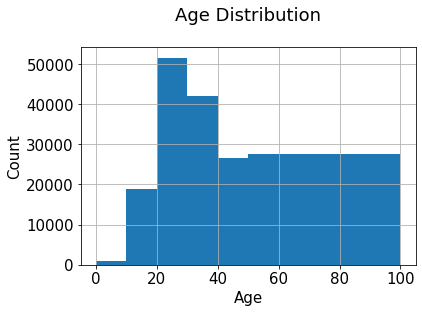

In [10]:
# The most active users are among those in their 20–30s.
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

# Recommendations based on rating counts

In [11]:
rating_count = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
rating_count.sort_values('bookRating', ascending=False).head()

,bookRating
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723


In [12]:
# The book with ISBN “0971880107” received the most rating counts. Let’s find out what book it is, and what books are in the top 5.
top_5_rated_books = pd.DataFrame(['0971880107', '0316666343', '0385504209', '0060928336', '0312195516'], index=np.arange(5), columns = ['ISBN'])
top_5_rated_books_summary = pd.merge(top_5_rated_books, books, on='ISBN')
top_5_rated_books_summary

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
2,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...


The book that received the most rating counts in this data set is Rich Shapero’s “Wild Animus”. And there is something in common among these five books that received the most rating counts — they are all novels. The recommender suggests that novels are popular and likely receive more ratings. And if someone likes “The Lovely Bones: A Novel”, we should probably also recommend to him(or her) “Wild Animus”.

# Recommendations based on correlations

We use Pearsons’R correlation coefficient to measure the linear correlation between two variables, in our case, the ratings for two books.

In [13]:
# We need to find out the average rating, and the number of ratings each book received.
average_rating = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,bookRating,ratingCount
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


Observations: In this data set, the book that received the most rating counts was not highly rated at all. As a result, if we were to use recommendations based on rating counts, we would definitely make mistakes here. So, we need to have a better system.

In [14]:
# To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

## Rating matrix

In [15]:
# We convert the ratings table to a 2D matrix. The matrix will be sparse because not every user rated every book.
ratings_pivot = ratings.pivot(index='userID', columns='ISBN').bookRating
userID = ratings_pivot.index
ISBN = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot.head()

(905, 207699)


ISBN,0330299891,0375404120,0586045007,9022906116,9032803328,9044922564,9044922572,9044922718,9044923161,904492401X,...,UNGRANDHOMMED,X000000000,"YOUTELLEM,AND",ZR903CX0003,"\0432534220\""""","\2842053052\""""",b00005wz75,cn108465,cn113107,Ô½crosoft
userID,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Let’s find out which books are correlated with the 2nd most rated book “The Lovely Bones: A Novel”.
bones_ratings = ratings_pivot['0316666343']
similar_to_bones = ratings_pivot.corrwith(bones_ratings)
corr_bones = pd.DataFrame(similar_to_bones, columns=['pearsonR'])
corr_bones.dropna(inplace=True)
corr_summary = corr_bones.join(average_rating['ratingCount'])
corr_summary[corr_summary['ratingCount']>=300].sort_values('pearsonR', ascending=False).head(10)

,pearsonR,ratingCount
ISBN,,
0316666343,1.000000,1295
0312291639,0.471872,354
0316601950,0.434248,568
0446610038,0.429712,391
0446672211,0.421478,585
0385265700,0.351635,319
0345342968,0.316922,321
0060930535,0.309860,494
0375707972,0.308145,354


In [17]:
# We obtained the books’ ISBNs, but we need to find out the titles of the books to see whether they make sense.
books_corr_to_bones = pd.DataFrame(['0312291639', '0316601950', '0446610038', '0446672211', '0385265700', '0345342968', '0060930535', '0375707972', '0684872153'], 
                                  index=np.arange(9), columns=['ISBN'])
corr_books = pd.merge(books_corr_to_bones, books, on='ISBN')
corr_books

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0312291639,The Nanny Diaries: A Novel,Emma McLaughlin,2003,St. Martin's Griffin,http://images.amazon.com/images/P/0312291639.0...,http://images.amazon.com/images/P/0312291639.0...,http://images.amazon.com/images/P/0312291639.0...
1,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999,Back Bay Books,http://images.amazon.com/images/P/0316601950.0...,http://images.amazon.com/images/P/0316601950.0...,http://images.amazon.com/images/P/0316601950.0...
2,0446610038,1st to Die: A Novel,James Patterson,2002,Warner Vision,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...
3,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...
4,0385265700,The Book of Ruth (Oprah's Book Club (Paperback)),Jane Hamilton,1990,Anchor,http://images.amazon.com/images/P/0385265700.0...,http://images.amazon.com/images/P/0385265700.0...,http://images.amazon.com/images/P/0385265700.0...
5,0345342968,Fahrenheit 451,RAY BRADBURY,1987,Del Rey,http://images.amazon.com/images/P/0345342968.0...,http://images.amazon.com/images/P/0345342968.0...,http://images.amazon.com/images/P/0345342968.0...
6,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...
7,0375707972,The Reader,Bernhard Schlink,1999,Vintage Books USA,http://images.amazon.com/images/P/0375707972.0...,http://images.amazon.com/images/P/0375707972.0...,http://images.amazon.com/images/P/0375707972.0...
8,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt,1999,Scribner,http://images.amazon.com/images/P/0684872153.0...,http://images.amazon.com/images/P/0684872153.0...,http://images.amazon.com/images/P/0684872153.0...


# Collaborative Filtering Using k-Nearest Neighbors (kNN)

In [18]:
# Starting from the original data set, we will be only looking at the popular books. 
# In order to find out which books are popular, we combine books data with ratings data.
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...


In [19]:
# We then group by book titles and create a new column for total rating count.
ombine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [20]:
# We combine the rating data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books.
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [21]:
# Let’s look at the statistics of total rating count:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   160576.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: totalRatingCount, dtype: float64


In [22]:
# The median book has been rated only once. Let’s look at the top of the distribution:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    5.000
0.910    6.000
0.920    7.000
0.930    7.000
0.940    8.000
0.950   10.000
0.960   11.000
0.970   14.000
0.980   19.000
0.990   31.000
Name: totalRatingCount, dtype: float64


About 1% of the books received 50 or more ratings. Because we have so many books in our data, we will limit it to the top 1%, and this will give us 2713 unique books.

In [23]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


## Filter to users in US and Canada only

In [24]:
# In order to improve computing speed, and not run into the “MemoryError” issue, 
# I will limit our user data to those in the US and Canada. 
# And then combine user data with the rating data and total rating count data
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')
us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa"
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"knoxville, tennessee, usa"
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"byron, minnesota, usa"
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"cordova, tennessee, usa"
5,16795,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"mechanicsville, maryland, usa"


## Implementing kNN

We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

## Finding the Nearest Neighbors

In [25]:
# We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and 
# we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. 
# Finally, we fit the model.
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

In [26]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

# Test our model and make some recommendations:

In this step, the kNN algorithm measures distance to determine the “closeness” of instances. It then classifies an instance by finding its nearest neighbors, and picks the most popular class among the neighbors.

In [27]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
ser = us_canada_user_rating_pivot.iloc[query_index, :]
ser1 = ser.to_numpy()
distances, indices = model_knn.kneighbors(ser1.reshape(1,-1), n_neighbors = 6)

In [28]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Faking It:

1: Fast Women, with distance of 0.5044008636697441:
2: The Mulberry Tree, with distance of 0.6580918140482093:
3: Full Tilt (Janet Evanovich's Full Series), with distance of 0.6849183674984961:
4: Midnight Bayou, with distance of 0.7004962484157233:
5: The Jester, with distance of 0.7173153793457687:


# Collaborative Filtering Using Matrix Factorization

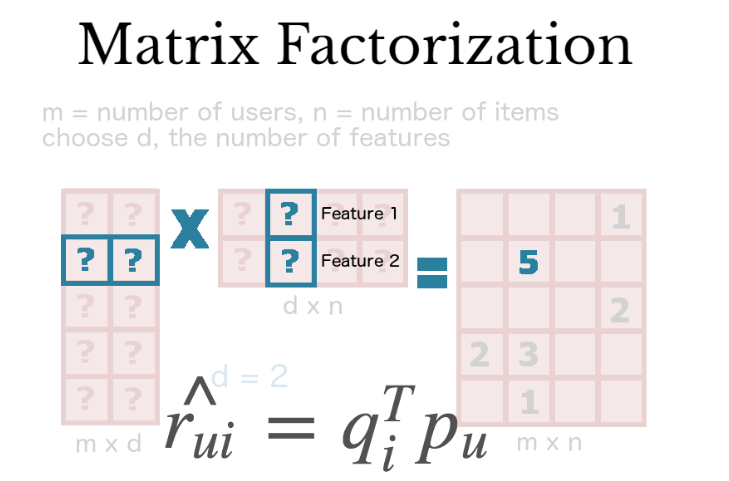

In [29]:
Image(filename='mf.png')

Matrix Factorization is simply a mathematical tool for playing around with matrices. The Matrix Factorization techniques are usually more effective, because they allow users to discover the latent (hidden)features underlying the interactions between users and items (books).

We use singular value decomposition (SVD) — one of the Matrix Factorization models for identifying latent factors.

In [30]:
# Similar with kNN, we convert our USA Canada user rating table into a 2D matrix (called a utility matrix here) 
# and fill the missing values with zeros.
us_canada_user_rating_pivot2 = us_canada_user_rating.pivot(index = 'userID', columns = 'bookTitle', values = 'bookRating').fillna(0)
us_canada_user_rating_pivot2.head()

bookTitle,1984,1st to Die: A Novel,2nd Chance,4 Blondes,84 Charing Cross Road,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Civil Action,A Cry In The Night,...,Winter Solstice,Wish You Well,Without Remorse,"Wizard and Glass (The Dark Tower, Book 4)",Wuthering Heights,Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw"""
userID,,,,,,,,,,,,,,,,,,,,,
254,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2276,0.000,0.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2766,0.000,0.000,0.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2977,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000
3363,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [31]:
# We then transpose this utility matrix, so that the bookTitles become rows and userIDs become columns. 
# After using TruncatedSVD to decompose it, we fit it into the model for dimensionality reduction. 
us_canada_user_rating_pivot2.shape

(734, 746)

In [32]:
X = us_canada_user_rating_pivot2.values.T
X.shape

(746, 734)

In [33]:
SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(746, 12)

In [34]:
# We calculate the Pearson’s R correlation coefficient for every book pair in our final matrix. 
# To compare this with the results from kNN, we pick the same book 
# to find the books that have high correlation coefficients (between 0.9 and 1.0) with it
corr = np.corrcoef(matrix)
corr.shape

(746, 746)

In [35]:
us_canada_book_title = us_canada_user_rating_pivot2.columns
us_canada_book_list = list(us_canada_book_title)
hot_book = us_canada_book_list.index(us_canada_user_rating_pivot.index[query_index])
print(hot_book)

192


In [36]:
corr_hot_book = corr[hot_book]
list(us_canada_book_title[(corr_hot_book < 1.0) & (corr_hot_book > 0.9)])

['Fast Women', 'The Surgeon']